In [214]:
#Pytket imports
from pytket import Circuit, OpType
from pytket.circuit import CircBox
from pytket.utils import compare_unitaries

#My imports
from qft_setup import build_inverse_qft
from utils_checks import qft_unitary_dag

In [215]:
n_measurement_qubits = 5 # How many qubits are we going to use to estimate the phase?
phase_input = 4/5 # Our phase we want to estimate

shots = 1000 # How many shots in our experiment?

In [216]:
# Check that inverse QFT is implemented correctly
compare_unitaries(build_inverse_qft(3).get_unitary(), qft_unitary_dag(3)) 

True

In [217]:
# We can wrap the inverse QFT subroutine up inside a CircBox Structure
inv_qft_box = CircBox(build_inverse_qft(n_measurement_qubits))

In [218]:
def build_qpe_circ(n_measurement_qubits: int, test_phase: float):
    """Constructs a phase estimation circuit to estimate the phase applied on
    qubit n+1 using n measurement qubits"""
    
    phase_circ = Circuit(n_measurement_qubits + 1, n_measurement_qubits)
    
    phase_circ.X(n_measurement_qubits)
    
    for j in range(n_measurement_qubits):
        phase_circ.H(j)
        
    for k in range(n_measurement_qubits):
        for l in range(2**k):
            phase_circ.add_gate(OpType.CU1,test_phase,[n_measurement_qubits - 1 - k, n_measurement_qubits])
                                 
    # Append inverse qft as gates
    #phase_circ.append(build_inverse_qft(n_measurement_qubits)) 
    
    # Append inverse qft as a box
    phase_circ.add_circbox(inv_qft_box, [x for x in range(n_measurement_qubits)], opgroup = "Inverse QFT")
    
    
    for m in range(n_measurement_qubits):
        phase_circ.Measure(m,m)
        
    return phase_circ


In [219]:
from pytket.circuit.display import render_circuit_jupyter

qpe_circ = build_qpe_circ(n_measurement_qubits, phase_input)

#render_circuit_jupyter(qpe_circ) # draw our phase estimation circuit

In [220]:
from pytket.passes import DecomposeBoxes

DecomposeBoxes().apply(qpe_circ) # Decompose the inverse QFT box structure

#render_circuit_jupyter(qpe_circ) # draw our circuit with the Decomposed box

True

In [221]:
# qasm_convert - creates a qpe.qasm file 
from pytket.qasm import circuit_to_qasm

circuit_to_qasm(qpe_circ, 'qpe.qasm')

In [222]:
from pytket.extensions.qiskit import IBMQEmulatorBackend

guadalupe_backend = IBMQEmulatorBackend('ibmq_guadalupe', hub ='partner-cqc', group ='internal', project ='default')
compiled_circ = guadalupe_backend.get_compiled_circuit(qpe_circ)

#render_circuit_jupyter(compiled_circ)
print("Number of gates in Circuit: ", compiled_circ.n_gates)
print("Number of CX gates in Circuit: ", compiled_circ.n_gates_of_type(OpType.CX))
print("CX Depth: ", compiled_circ.depth_by_type(OpType.CX))

Number of gates in Circuit:  226
Number of CX gates in Circuit:  118
CX Depth:  105


In [223]:
handle = guadalupe_backend.process_circuit(compiled_circ, shots)
my_result = guadalupe_backend.get_result(handle)
#my_result.get_counts() 

Green counts: 318 out of 1000 shots.


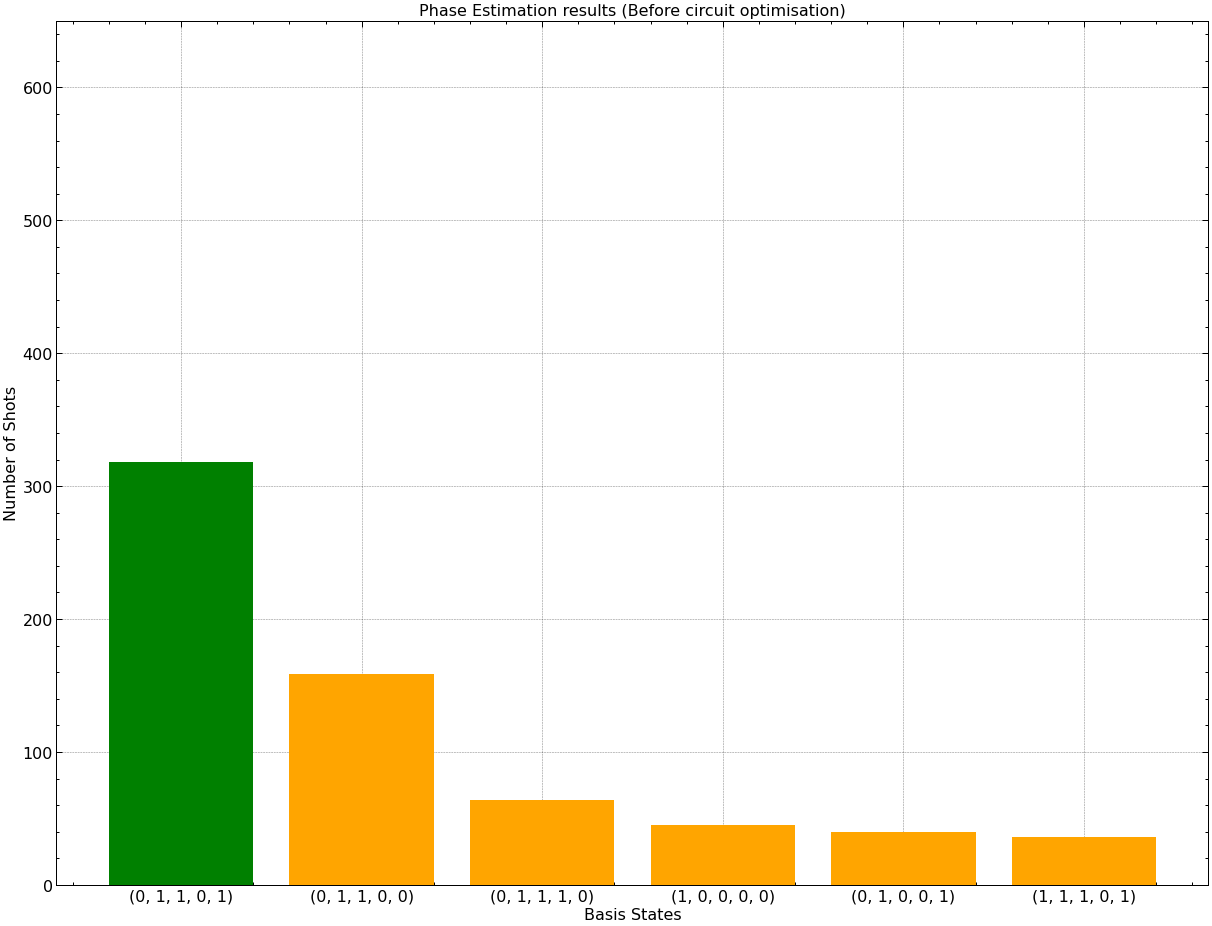

In [224]:
from plotting import plot_results # Import plotting from plotting.py file

rank_number = 6 # Choose the number of basis states to include in the plot.

plot_results(my_result, rank = rank_number, title = 'Phase Estimation results (Before circuit optimisation)',save_png=True, optimisation=False)

In [225]:
# In this cell we define our placement and qubit routing method
from pytket.placement import NoiseAwarePlacement
from pytket.passes import CXMappingPass

guadalupe_info = guadalupe_backend.backend_info
guadalupe_placer = NoiseAwarePlacement(arc = guadalupe_info.architecture,
                                       node_errors = guadalupe_info.averaged_node_gate_errors,
                                       link_errors = guadalupe_info.averaged_edge_gate_errors,
                                       readout_errors = guadalupe_info.averaged_readout_errors)


guadalupe_mapping_pass = CXMappingPass(
    guadalupe_info.architecture,
    guadalupe_placer,
    directed_cx = False
)

In [226]:
# In this cell we define our rebase to our IBM gateset and our sequence of compiler passes
from pytket.passes import (
    SequencePass,
    FullPeepholeOptimise,
    RemoveRedundancies,
)
from pytket.passes import auto_rebase_pass

ibm_rebase = auto_rebase_pass({OpType.CX, OpType.X, OpType.SX, OpType.Rz})

sequence_pass = SequencePass([FullPeepholeOptimise(), guadalupe_mapping_pass, ibm_rebase, RemoveRedundancies()])
sequence_pass.apply(compiled_circ)

#guadalupe_backend.default_compilation_pass(2).apply(compiled_circ)

print("Number of gates in Circuit: ", compiled_circ.n_gates)
print("Number of CX gates in Circuit: ", compiled_circ.n_gates_of_type(OpType.CX))
print("CX Depth: ", compiled_circ.depth_by_type(OpType.CX))
#render_circuit_jupyter(compiled_circ)

Number of gates in Circuit:  154
Number of CX gates in Circuit:  60
CX Depth:  48


In [227]:
handle = guadalupe_backend.process_circuit(compiled_circ, shots)
my_result_opt = guadalupe_backend.get_result(handle)
#my_result_opt.get_counts() # Display counts for optimised circuit

Green counts: 530 out of 1000 shots.


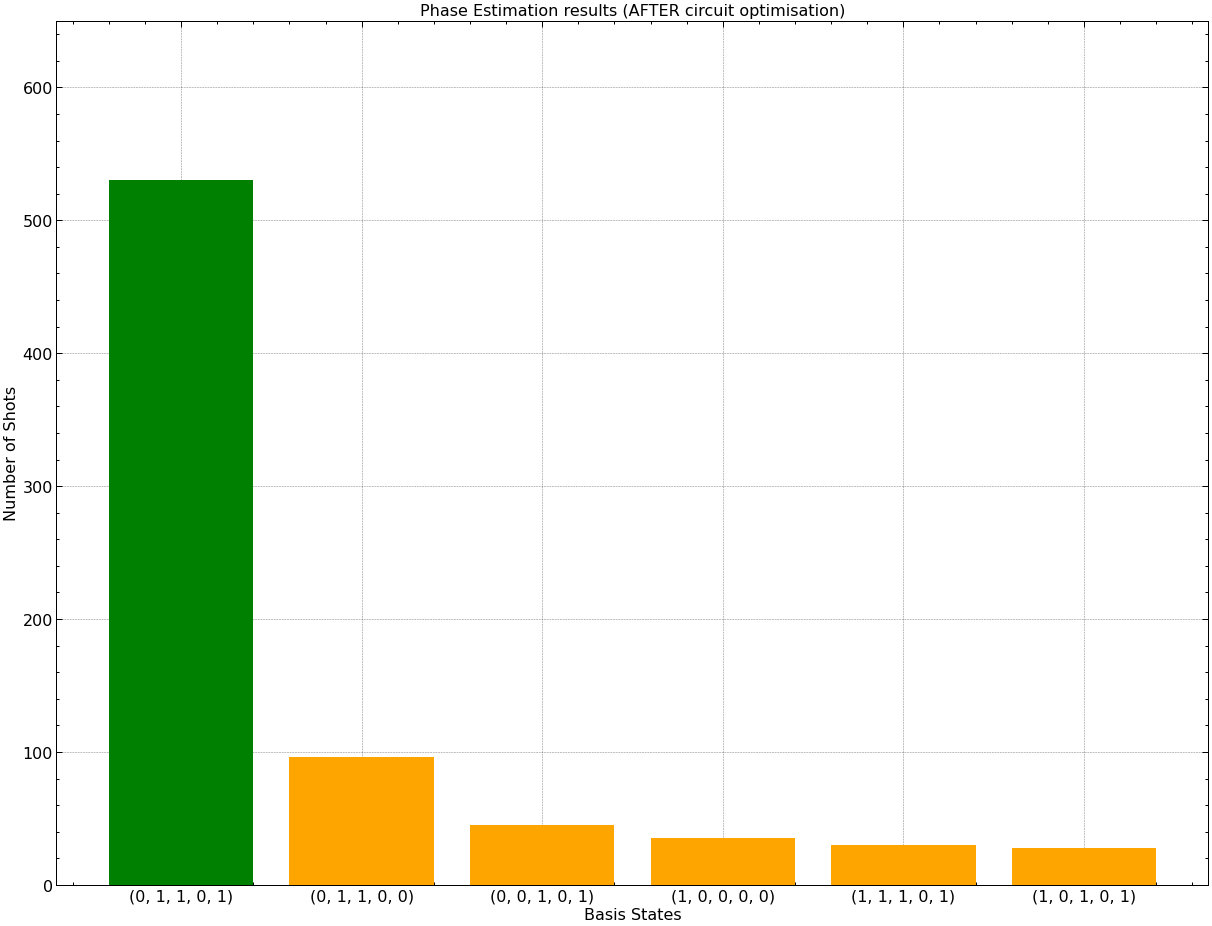

In [228]:
plot_results(my_result_opt, rank = rank_number , title = 'Phase Estimation results (AFTER circuit optimisation)', save_png=True, optimisation=True)

In [229]:
# Now we have to extract our phase information from our measurement results

# Most probable basis state result as a tuple
max_key = max(my_result_opt.get_counts(), key = my_result_opt.get_counts().get)

# Convert this tuple to a string
def tuple_to_string2(tup: tuple) -> str: 
    """
    Converts a tuple to a string as follows (1,0,0) -> '100'
    """
    mystring = ''
    for entry in tup :
        mystring += str(entry)
        
    return mystring

highest_probability_string = tuple_to_string2(max_key)

decimal_output = int(highest_probability_string, 2) # Convert from binary string to a decimal
        
phase_estimate = decimal_output / (2 ** n_measurement_qubits)

naive_error = round(abs(phase_estimate - phase_input / 2), 4)

def percentage_error(error: float):
    """
    Returns the naive error percentage between the input phase and the measured phase.
    """
    percentage = round(2 * error / phase_input * 100, 1) #percentage error rounded to 1dp
    print( "Naive error percentage = {}%".format(percentage))

In [230]:
# Our "winning" basis state
highest_probability_string

'01101'

In [231]:
decimal_output # Divide this by 2 ** n_measurement_qubits to get phase

13

In [232]:
# This is our phase estimate... Ideally it should equal phase_input / 2
phase_estimate

0.40625

In [233]:
# Expected answer
phase_input / 2

0.4

In [234]:
naive_error # How much did we miss our expected result by? absolute value to 4dp

0.0062

In [235]:
percentage_error(naive_error) # percentage error to 1dp

Naive error percentage = 1.5%
